In [1]:
!ngrok authtoken "2lQehFbtavcCd2ux1ynNPHc4lJo_6Jzm1pDJiKyKvtMMfZnTu"

/bin/bash: line 1: ngrok: command not found


In [2]:
!pip install flask_ngrok pyngrok sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 7.5 MB/s eta 0:00:00


In [3]:
import os
import glob
import pickle
import numpy as np
import pandas as pd
from pyngrok import ngrok
from datetime import datetime
from google.colab import drive
from flask_ngrok import run_with_ngrok
from sklearn.preprocessing import StandardScaler
from flask import Flask, render_template, request, jsonify

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sentence_transformers import SentenceTransformer
import pandas as pd
import pickle

# Specify the path to the saved model file
model_file_path = 'moodels1/decision_tree_reg_latest.pkl'

# Load the model from the file
with open(model_file_path, 'rb') as model_file:
    loaded_decision_tree_reg = pickle.load(model_file)


import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Define the PCA and StandardScaler objects
n_components = 23  # Adjust the number of components as needed
pca = PCA(n_components=n_components)
scaler = StandardScaler()

# Load the Sentence Transformer model
model = SentenceTransformer('flax-sentence-embeddings/all_datasets_v4_MiniLM-L6')  # Replace with your actual model name or path


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


**Predict function to predict the `Hotel Price per person`**

In [ ]:
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Initialize the SentenceTransformer model
model = SentenceTransformer('flax-sentence-embeddings/all_datasets_v4_MiniLM-L6')

# Create a function for prediction
def predict_price(input_data, lr_model, pca, scaler):
    # Prepare the input data
    text_columns = [
        'Package Name', 'Destination', 'Itinerary', 'Places Covered',
        'Hotel Details', 'Airline', 'Sightseeing Places Covered', 'Cancellation Rules'
    ]

    # Initialize an empty DataFrame
    df = pd.DataFrame([input_data])

    # Encode text-based columns and create embeddings
    for column in text_columns:
        df[column + '_embedding'] = df[column].apply(lambda text: model.encode(text))

    # Apply PCA separately to each text embedding column
    n_components = 23  # Adjust the number of components as needed
    text_embeddings_pca = np.empty((len(df), n_components * len(text_columns)))

    for i, column in enumerate(text_columns):
        embeddings = df[column + '_embedding'].values.tolist()
        embeddings_pca = pca.transform(embeddings)
        text_embeddings_pca[:, i * n_components:(i + 1) * n_components] = embeddings_pca

    # Combine text embeddings with other numerical features if available
    numerical_features = [
        'Package Type_Standard', 'Package Type_Premium', 'Package Type_Luxury',
        'Travel_Month', 'Package Type_Budget', 'Package Type_Deluxe',
        'Hotel Ratings', 'Start City_New Delhi', 'Start City_Mumbai',
        'Travel_DayOfWeek', 'Travel_Year'
    ]

    X_numerical = df[numerical_features].values

    # Combine PCA-transformed text embeddings and numerical features
    X = np.hstack((text_embeddings_pca, X_numerical))

    # Scale the data using the same scaler used during training
    X = scaler.transform(X)

    # Make predictions using the trained Linear Regression model
    y_pred = lr_model.predict(X)

    return y_pred[0]

In [ ]:
df_input = pd.read_csv('/content/drive/MyDrive/models1/makemytrip__data.csv',on_bad_lines='skip')


# Filling missing values for Hotel Details with 'Not Available'
df_input['Hotel Details'].fillna('Not Available', inplace=True)

# Filling missing values for Airline with 'Not Available'
df_input['Airline'].fillna('Not Available', inplace=True)

# Filling missing values for Onwards Return Flight Time with 'Not Available'
df_input['Onwards Return Flight Time'].fillna('Not Available', inplace=True)

# Filling missing values for Sightseeing Places Covered with 'Not Available'
df_input['Sightseeing Places Covered'].fillna('Not Available', inplace=True)

# Filling missing values for Initial Payment For Booking with 0 (assuming no initial payment)
df_input['Initial Payment For Booking'].fillna(0, inplace=True)

# Filling missing values for Cancellation Rules with 'Not Available'
df_input['Cancellation Rules'].fillna('Not Available', inplace=True)

# Dropping columns with all missing values (Flight Stops, Date Change Rules, Unnamed: 22, Unnamed: 23)
df_input.drop(columns=["Flight Stops", "Meals", "Initial Payment For Booking", "Date Change Rules"], inplace=True)
df_input['Travel Date'] = pd.to_datetime(df_input['Travel Date'], format='%d-%m-%Y', errors='coerce')
allowed_package_types = ['Deluxe', 'Standard', 'Premium', 'Luxury', 'Budget']

# Filter the DataFrame to keep only the rows with allowed package types
df_input = df_input[df_input['Package Type'].isin(allowed_package_types)]
df_input.drop('Company', axis=1, inplace=True)
df_input.drop('Crawl Timestamp', axis=1, inplace=True)

# Extracting hotel ratings from Hotel Details
df_input['Hotel Ratings'] = df_input['Hotel Details'].str.extract(r'(\d+\.\d+)')

# Convert 'Hotel Ratings' to numeric (float)
df_input['Hotel Ratings'] = pd.to_numeric(df_input['Hotel Ratings'], errors='coerce')

# Calculate the mode of the 'Hotel Ratings' column
mode_rating = df_input['Hotel Ratings'].mode()[0]

# Replace NaN values with the mode
df_input['Hotel Ratings'].fillna(mode_rating, inplace=True)

# Assuming your data is stored in a DataFrame called 'df_input'
df_input['Travel Date'] = pd.to_datetime(df_input['Travel Date'])
df_input['Travel_Year'] = df_input['Travel Date'].dt.year
df_input['Travel_Month'] = df_input['Travel Date'].dt.month
df_input['Travel_DayOfWeek'] = df_input['Travel Date'].dt.dayofweek

# Example of one-hot encoding
df_input = pd.get_dummies(df_input, columns=['Package Type','Start City'])

Q1 = df_input['Per Person Price'].quantile(0.25)
Q3 = df_input['Per Person Price'].quantile(0.75)
IQR = Q3 - Q1

# Step 2: Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 3: Filter the DataFrame to remove outliers
df_input = df_input[(df_input['Per Person Price'] >= lower_bound) & (df_input['Per Person Price'] <= upper_bound)]


In [ ]:
row_index = 100  # Replace with the desired row index

# Access the row from df_input using iloc
input_row = df_input.iloc[row_index]

# Create an input dictionary from the selected row
input_data = {
    'Package Name': input_row['Package Name'],
    'Destination': input_row['Destination'],
    'Itinerary': input_row['Itinerary'],
    'Places Covered': input_row['Places Covered'],
    'Hotel Details': input_row['Hotel Details'],
    'Airline': input_row['Airline'],
    'Sightseeing Places Covered': input_row['Sightseeing Places Covered'],
    'Cancellation Rules': input_row['Cancellation Rules'],
    'Package Type_Standard': input_row['Package Type_Standard'],
    'Package Type_Premium': input_row['Package Type_Premium'],
    'Package Type_Luxury': input_row['Package Type_Luxury'],
    'Travel_Month': input_row['Travel_Month'],
    'Package Type_Budget': input_row['Package Type_Budget'],
    'Package Type_Deluxe': input_row['Package Type_Deluxe'],
    'Hotel Ratings': input_row['Hotel Ratings'],
    'Start City_New Delhi': input_row['Start City_New Delhi'],
    'Start City_Mumbai': input_row['Start City_Mumbai'],
    'Travel_DayOfWeek': input_row['Travel_DayOfWeek'],
    'Travel_Year': input_row['Travel_Year']
}
import joblib

# Load the models from the files
loaded_lr_model = joblib.load('/content/drive/MyDrive/models/lr_model.joblib')
loaded_pca = joblib.load('/content/drive/MyDrive/models/pca.joblib')
loaded_scaler = joblib.load('/content/drive/MyDrive/models/scaler.joblib')

predicted_price = str(predict_price(input_data, loaded_lr_model, loaded_pca, loaded_scaler))[-10:]
print(f'Predicted Per Person Price: ${predicted_price}')


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid r

Predicted Per Person Price: $96276.9947


input_features:

       ['Price Per Two Persons', 'Package Type_Standard',
       'Package Type_Premium', 'Package Type_Luxury', 'Travel_Month',
       'Package Type_Budget', 'Package Type_Deluxe', 'Hotel Ratings',
       'Start City_New Delhi', 'Start City_Mumbai', 'Travel_DayOfWeek',
       'Travel_Year']

## Flask-API

We will use `flask-ngrok` and `run_with_ngrok` in Google Colab for following reasons:

1. **Local Server Limitation:** When you run a web application in Colab, it's like having a little website, but in Colab you can't access the website on localhost. So to overcome this limitation, you need a way to give it a temporary public web address.

2. **Sharing Over the Internet**: If you want to show your web app to others or access it from your own device, you need a way to make it available online.

3. **Flask-Ngrok**: `flask-ngrok` is a tool that helps with this. It teams up with another service called ngrok to give your Colab web app a temporary public web address that anyone can visit.

----

Things we need to do:

1. **Flask Web Application**: We create a Flask web application to serve as an API endpoint.

2. **Load Trained Model**: We load a trained regression model (you should replace this with your actual model loading code).

3. **Prediction Function**: We define a function (`predict_value`) to make predictions using the loaded model.

4. **User Input Processing**: In the `/predict` route, we collect user input data from an HTML form, including price, travel details, and other parameters.

5. **Data Preparation**: We prepare the user input data and convert it into a format suitable for making predictions.

6. **Prediction**: Using the loaded model, we make predictions based on the user's input.

7. **JSON Response**: We return the prediction result as a JSON response to the API request.

8. **HTML Form**: If the request is a GET request, we display an HTML form to collect user input.

9. **Styling**: You can customize the HTML form and add CSS styling to make it visually appealing.

10. **Run the Flask App**: The Flask app is run, allowing users to access it and receive predictions through API requests.

In [ ]:
pip install flask-ngrok


In [ ]:
!ngrok authtoken "2lQehFbtavcCd2ux1ynNPHc4lJo_6Jzm1pDJiKyKvtMMfZnTu"

from flask import Flask, request, jsonify
from flask_ngrok import run_with_ngrok

app = Flask(__name__)
run_with_ngrok(app)  # This should start ngrok automatically

@app.route('/', methods=['GET', 'POST'])
def predict():
    return """

    <!DOCTYPE html>
<html>
<head>
    <title>Travel Package Prediction</title>
    <style>
        body {
            font-family: 'Poppins', sans-serif;
            background-color: #f9f9f9;
            margin: 0;
            padding: 0;
        }

        .container {
            max-width: 800px;
            margin: 0 auto;
            padding: 40px;
            background-color: #ffffff;
            border-radius: 10px;
            box-shadow: 0 10px 20px rgba(0, 0, 0, 0.1);
            text-align: center;
        }

        h1 {
            color: #007BFF;
            font-size: 36px;
            margin-bottom: 20px;
        }

        form {
            text-align: left;
        }

        input[type="text"],
        input[type="number"] {
            width: 100%;
            padding: 15px;
            margin: 15px 0;
            border: none;
            border-bottom: 2px solid #007BFF;
            font-size: 18px;
            background-color: transparent;
            color: #333;
            transition: border-bottom 0.3s ease;
        }

        input[type="text"]:focus,
        input[type="number"]:focus {
            border-bottom: 2px solid #0056b3;
            outline: none;
        }

        input[type="checkbox"],
        input[type="radio"] {
            margin-right: 10px;
        }

        input[type="submit"] {
            background-color: #007BFF;
            color: #fff;
            padding: 15px 30px;
            border: none;
            border-radius: 5px;
            cursor: pointer;
            font-size: 20px;
            transition: background-color 0.3s ease;
        }

        input[type="submit"]:hover {
            background-color: #0056b3;
        }

        p#prediction {
            margin-top: 20px;
            font-size: 24px;
            color: #007BFF;
        }
    </style>
</head>
<body>
    <div class="container">
        <h1>Travel Package Prediction</h1>
        <form action="/predict" method="POST">
            <label for="Package Name">Package Name:</label>
            <input type="text" name="Package Name" placeholder="Custom Package" value="A Grand Week in North East - Lachung Special">

            <label for="Destination">Destination:</label>
            <input type="text" name="Destination" placeholder="Custom Destination" value="Gangtok|Lachung|Gangtok|Darjeeling">

            <label for="Itinerary">Itinerary:</label>
            <input type="text" name="Itinerary" placeholder="Custom Itinerary" value="2N Gangtok . 2N Lachung . 1N Gangtok . 2N Darjeeling">

            <label for="Places Covered">Places Covered:</label>
            <input type="text" name="Places Covered" placeholder="Custom Places" value="Gangtok|Lachung|Gangtok|Darjeeling">

            <label for="Hotel Details">Hotel Details:</label>
            <input type="text" name="Hotel Details" placeholder="Custom Hotel Details" value="Lemon Tree Hotel  Gangtok:4.2|Summit Alpine Resort, Lachung- MMT Holidays Special:4.2|Lemon Tree Hotel  Gangtok:4.4|Ramada by Wyndham Darjeeling Gandhi Road:">

            <label for="Airline">Airline:</label>
            <input type="text" name="Airline" placeholder="Custom Airline" value="Air India|IndiGo">

            <label for="Sightseeing Places Covered">Sightseeing Places Covered:</label>
            <input type="text" name="Sightseeing Places Covered" placeholder="Custom Sightseeing" value="Baba Mandir | MG Road - Walk | Visit to Lake Tsomgo with Yak Safari | Snacks at Changu lake (Winter Special) | Yumthang Valley | Hot Spring">

            <label for="Cancellation Rules">Cancellation Rules:</label>
            <input type="text" name="Cancellation Rules" placeholder="Custom Cancellation Rules" value="Not Available">


            <label for="Package Type_Standard">Package Type_Standard:</label>
            <input type="checkbox" name="Package Type_Standard" value="1" checked>

            <label for="Package Type_Premium">Package Type_Premium:</label>
            <input type="checkbox" name="Package Type_Premium" value="1">

            <label for="Package Type_Luxury">Package Type_Luxury:</label>
            <input type="checkbox" name="Package Type_Luxury" value="1">

            <label for="Travel_Month">Travel Month:</label>
            <input type="number" name="Travel_Month" min="1" max="12" placeholder="Travel Month" value="5">

            <label for="Package Type_Budget">Package Type_Budget:</label>
            <input type="checkbox" name="Package Type_Budget" value="1">

            <label for="Package Type_Deluxe">Package Type_Deluxe:</label>
            <input type="checkbox" name="Package Type_Deluxe" value="1">

            <label for="Hotel Ratings">Hotel Ratings:</label>
            <input type="number" name="Hotel Ratings" placeholder="Hotel Ratings" value="4.5">

            <label for="Start City_New Delhi">Start City_New Delhi:</label>
            <input type="checkbox" name="Start City_New Delhi" value="1">

            <label for="Start City_Mumbai">Start City_Mumbai:</label>
            <input type="checkbox" name="Start City_Mumbai" value="1">

            <label for="Travel_DayOfWeek">Travel Day of Week:</label>
            <input type="number" name="Travel_DayOfWeek" min="0" max="6" placeholder="Travel Day of Week" value="2">

            <label for="Travel_Year">Travel Year:</label>
            <input type="number" name="Travel_Year" min="2023" max="2123" placeholder="Travel Year" value="2023">

            <input type="submit" value="Predict">
        </form>
        <p id="prediction"></p>
    </div>
</body>
</html>


    """


@app.route('/predict', methods=['POST'])
def index():
    if request.method == 'POST':
        # Get input data from the form
        package_name = request.form.get('Package Name')
        destination = request.form.get('Destination')
        itinerary = request.form.get('Itinerary')
        places_covered = request.form.get('Places Covered')
        hotel_details = request.form.get('Hotel Details')
        airline = request.form.get('Airline')
        sightseeing_places = request.form.get('Sightseeing Places Covered')
        cancellation_rules = request.form.get('Cancellation Rules')
        package_standard = int(request.form.get('Package Type_Standard', 0))
        package_premium = int(request.form.get('Package Type_Premium', 0))
        package_luxury = int(request.form.get('Package Type_Luxury', 0))
        travel_month = int(request.form.get('Travel_Month'))
        package_budget = int(request.form.get('Package Type_Budget', 0))
        package_deluxe = int(request.form.get('Package Type_Deluxe', 0))
        hotel_ratings = float(request.form.get('Hotel Ratings'))
        start_city_delhi = int(request.form.get('Start City_New Delhi', 0))
        start_city_mumbai = int(request.form.get('Start City_Mumbai', 0))
        travel_day_of_week = int(request.form.get('Travel_DayOfWeek'))
        travel_year = int(request.form.get('Travel_Year'))

        # Create a dictionary to store the input data
        data = {
            'Package Name': package_name,
            'Destination': destination,
            'Itinerary': itinerary,
            'Places Covered': places_covered,
            'Hotel Details': hotel_details,
            'Airline': airline,
            'Sightseeing Places Covered': sightseeing_places,
            'Cancellation Rules': cancellation_rules,
            'Package Type_Standard': package_standard,
            'Package Type_Premium': package_premium,
            'Package Type_Luxury': package_luxury,
            'Travel_Month': travel_month,
            'Package Type_Budget': package_budget,
            'Package Type_Deluxe': package_deluxe,
            'Hotel Ratings': hotel_ratings,
            'Start City_New Delhi': start_city_delhi,
            'Start City_Mumbai': start_city_mumbai,
            'Travel_DayOfWeek': travel_day_of_week,
            'Travel_Year': travel_year
        }

        # Perform prediction using the custom_input dictionary
        prediction = predict_price(data, loaded_lr_model, loaded_pca, loaded_scaler)//10
        prediction = str(prediction)[-7:]

        return jsonify({'prediction': prediction})


if __name__ == "__main__":
    app.run()

## Click on the link that's saying `Running on http://________.ngrok-free.app`

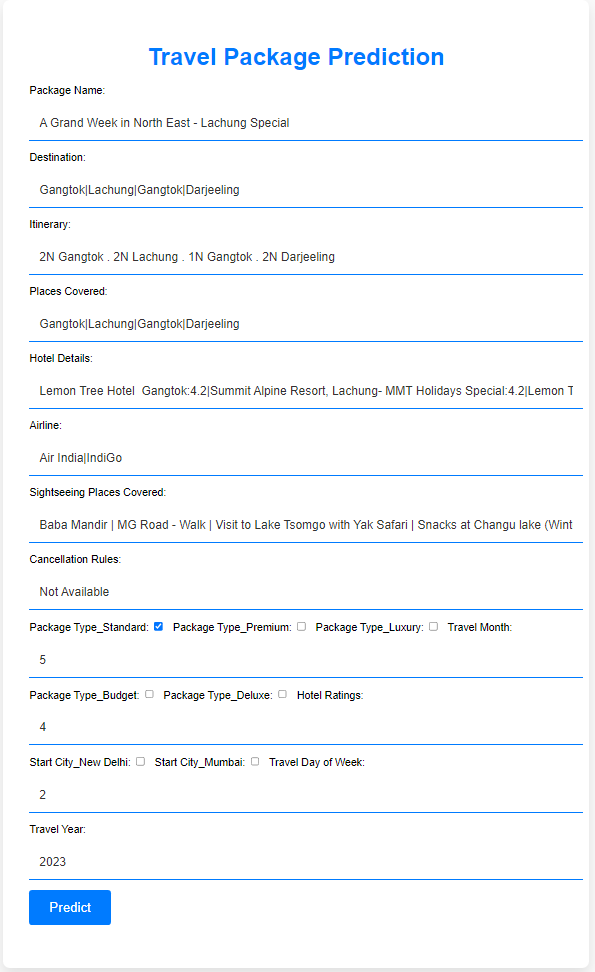